In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter

In [2]:
# this is the flare model implemented in theano

def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 20.)).nonzero()
        flare_lc = _flaremodel(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
#     for i in range(npeaks):
#         tcut = (((t - tpeaks[i])/fwhms[i] > -1.) * ((t - tpeaks[i])/fwhms[i] < 20.)).nonzero()
#         flare_lc = _flaremodel(t[tcut], tpeaks[i], fwhms[i], ampls[i])
#         multiflare_lc = tt.set_subtensor(multiflare_lc[tcut],  multiflare_lc[tcut] + flare_lc)
    return multiflare_lc

def _flaremodel(t, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                        before_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                        after_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    return flare_lc

def before_flare(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    fout = ((_fr[0] + _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl)
    return fout

def after_flare(t, tpeak, fwhm, ampl):
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    fout = ((_fd[0] * tt.exp( ((t - tpeak) / fwhm) * _fd[1]) +
             _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
            ampl)
    return fout

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
npeaks = 10
multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    multiflaremodel(xx, tpeaksx, fwhmsx, amplsx))

In [3]:
# reference implementation in numpy
def multiflaremodelnp(t, tpeaks, fwhms, ampls):
    multiflare_lc = np.zeros_like(t)
    npeaks = tpeaks.shape[0]
    for i in range(npeaks):
        flare_lc = flaremodelnp(t, tpeaks[i], fwhms[i], ampls[i])
        multiflare_lc = multiflare_lc + flare_lc
    return multiflare_lc

def flaremodelnp(t, tpeak, fwhm, ampl, oversample=10):
    # reuses some code from AltaiPony and Apaloosa
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    flare_lc = np.zeros_like(t)
    flare_lc = np.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                       (_fr[0] +
                        _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl,
                        flare_lc
                       )
    flare_lc = np.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                       (_fd[0] * np.exp( ((t - tpeak) / fwhm)*_fd[1] ) +
                        _fd[2] * np.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
                        ampl,
                        flare_lc
                       )
    return flare_lc

In [4]:
# create some signals
t = np.arange(0,10,2/1440)
tpeaks = np.random.choice(t, size=10)
fwhms = np.random.random(size=10) / 30
ampls = np.random.random(size=10)*10

2.0842702563861337e-15

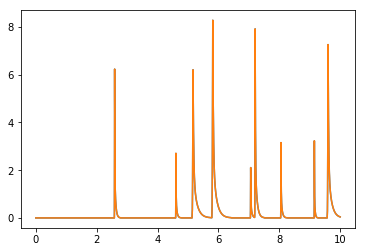

In [13]:
plt.plot(t, multiflaremodelnp(t, tpeaks, fwhms, ampls))
plt.plot(t, multiflare(t, tpeaks, fwhms, ampls))
# plt.xlim(2000,2500)
np.sum(multiflaremodelnp(t, tpeaks, fwhms, ampls) - multiflare(t, tpeaks, fwhms, ampls))

In [6]:
# inject some signals
x = np.copy(t)
y = multiflaremodelnp(t, tpeaks, fwhms, ampls) + np.random.normal(size=np.shape(x)[0])

In [7]:
%timeit multiflaremodelnp(x, tpeaks, fwhms, ampls)

9.71 ms ± 84.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%timeit multiflare(x, tpeaks, fwhms, ampls)

510 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
# create a pymc3 model
with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.05,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    flare_lc = multiflaremodel(x, tpeak, fwhm, ampl)
    pm.Deterministic("flare_lc", flare_lc)
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)

In [15]:
sampler = xo.PyMC3Sampler(window=200, start=200, finish=200)
with model:
    burnin = sampler.tune(tune=3000, step_kwargs=dict(target_accept=0.9))

Sampling 4 chains: 100%|██████████| 808/808 [01:49<00:00,  3.37draws/s]


In [18]:
start, step = sampler._get_start_and_step()
with model:
    step = pm.NUTS(potential=step.potential, target_accept=0.9)
    trace = pm.sample(draws=3000, tune=200, step=step, start=start)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]
INFO:pymc3:NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]
Sampling 4 chains: 100%|██████████| 12800/12800 [50:18<00:00,  1.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd1d135128>,
      dtype=object)

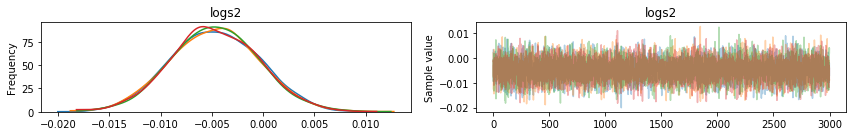

In [30]:
pm.traceplot(trace, varnames=['logs2'])

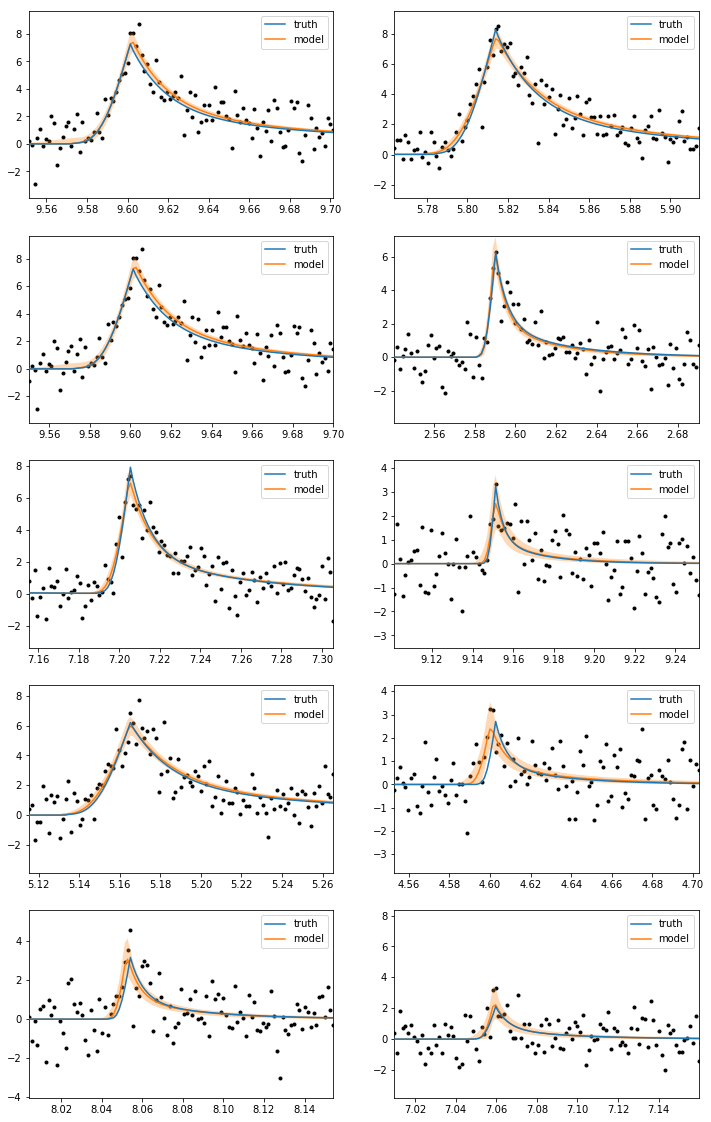

In [50]:
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
#     ax.plot(x[timemask], multiflare(x[timemask], tpeaks[i], fwhms[i], ampls[i]),
#                                      ':b')
    ax.plot(x[timemask], multiflare(x[timemask], tpeaks, fwhms, ampls), label='truth', zorder=1000)
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()

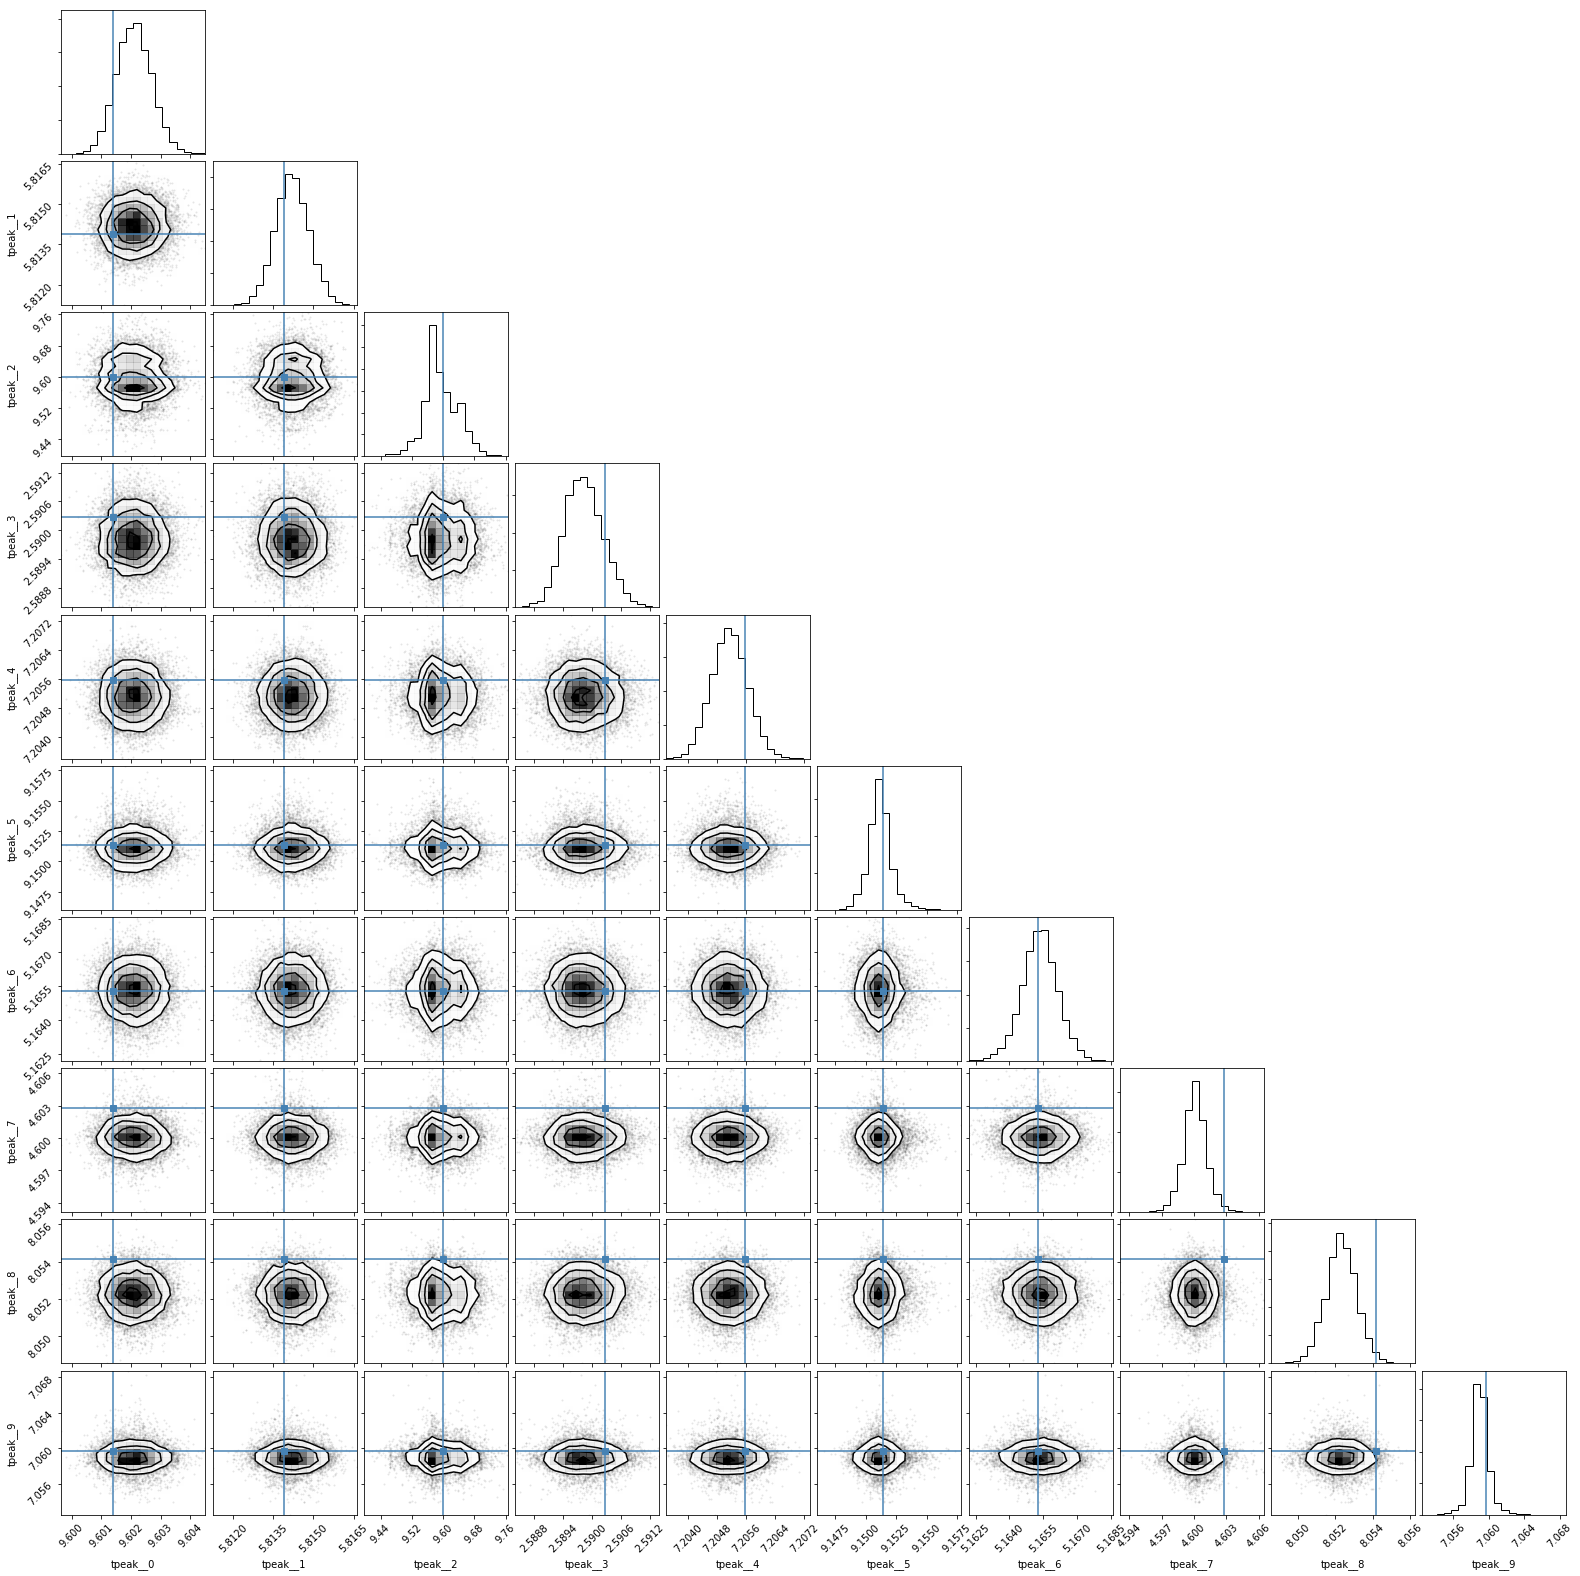

In [26]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=['tpeak'])
corner.corner(samples, truths=tpeaks);

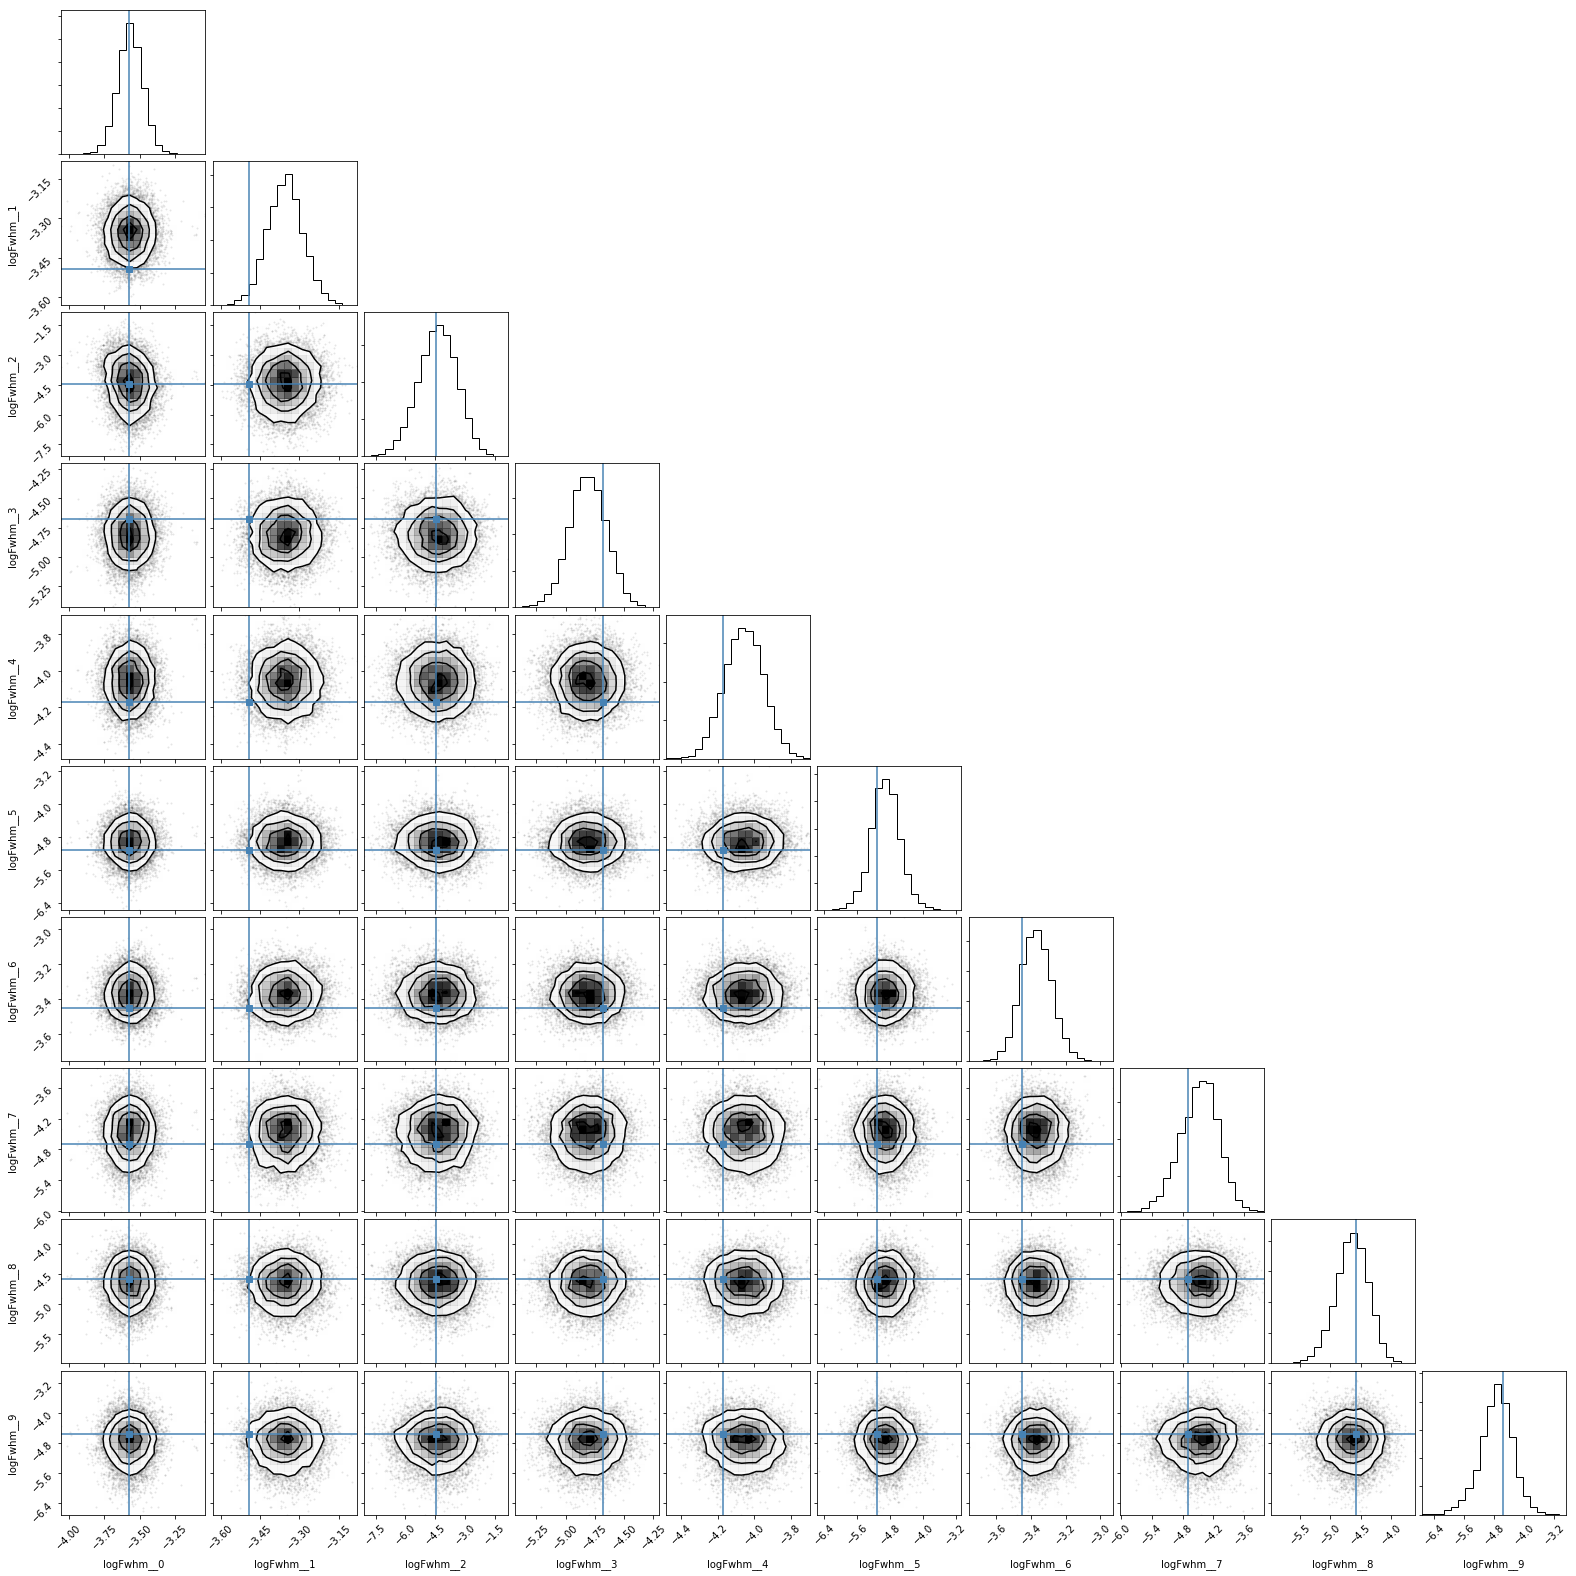

In [31]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=['logFwhm'])
corner.corner(samples, truths=np.log(fwhms));

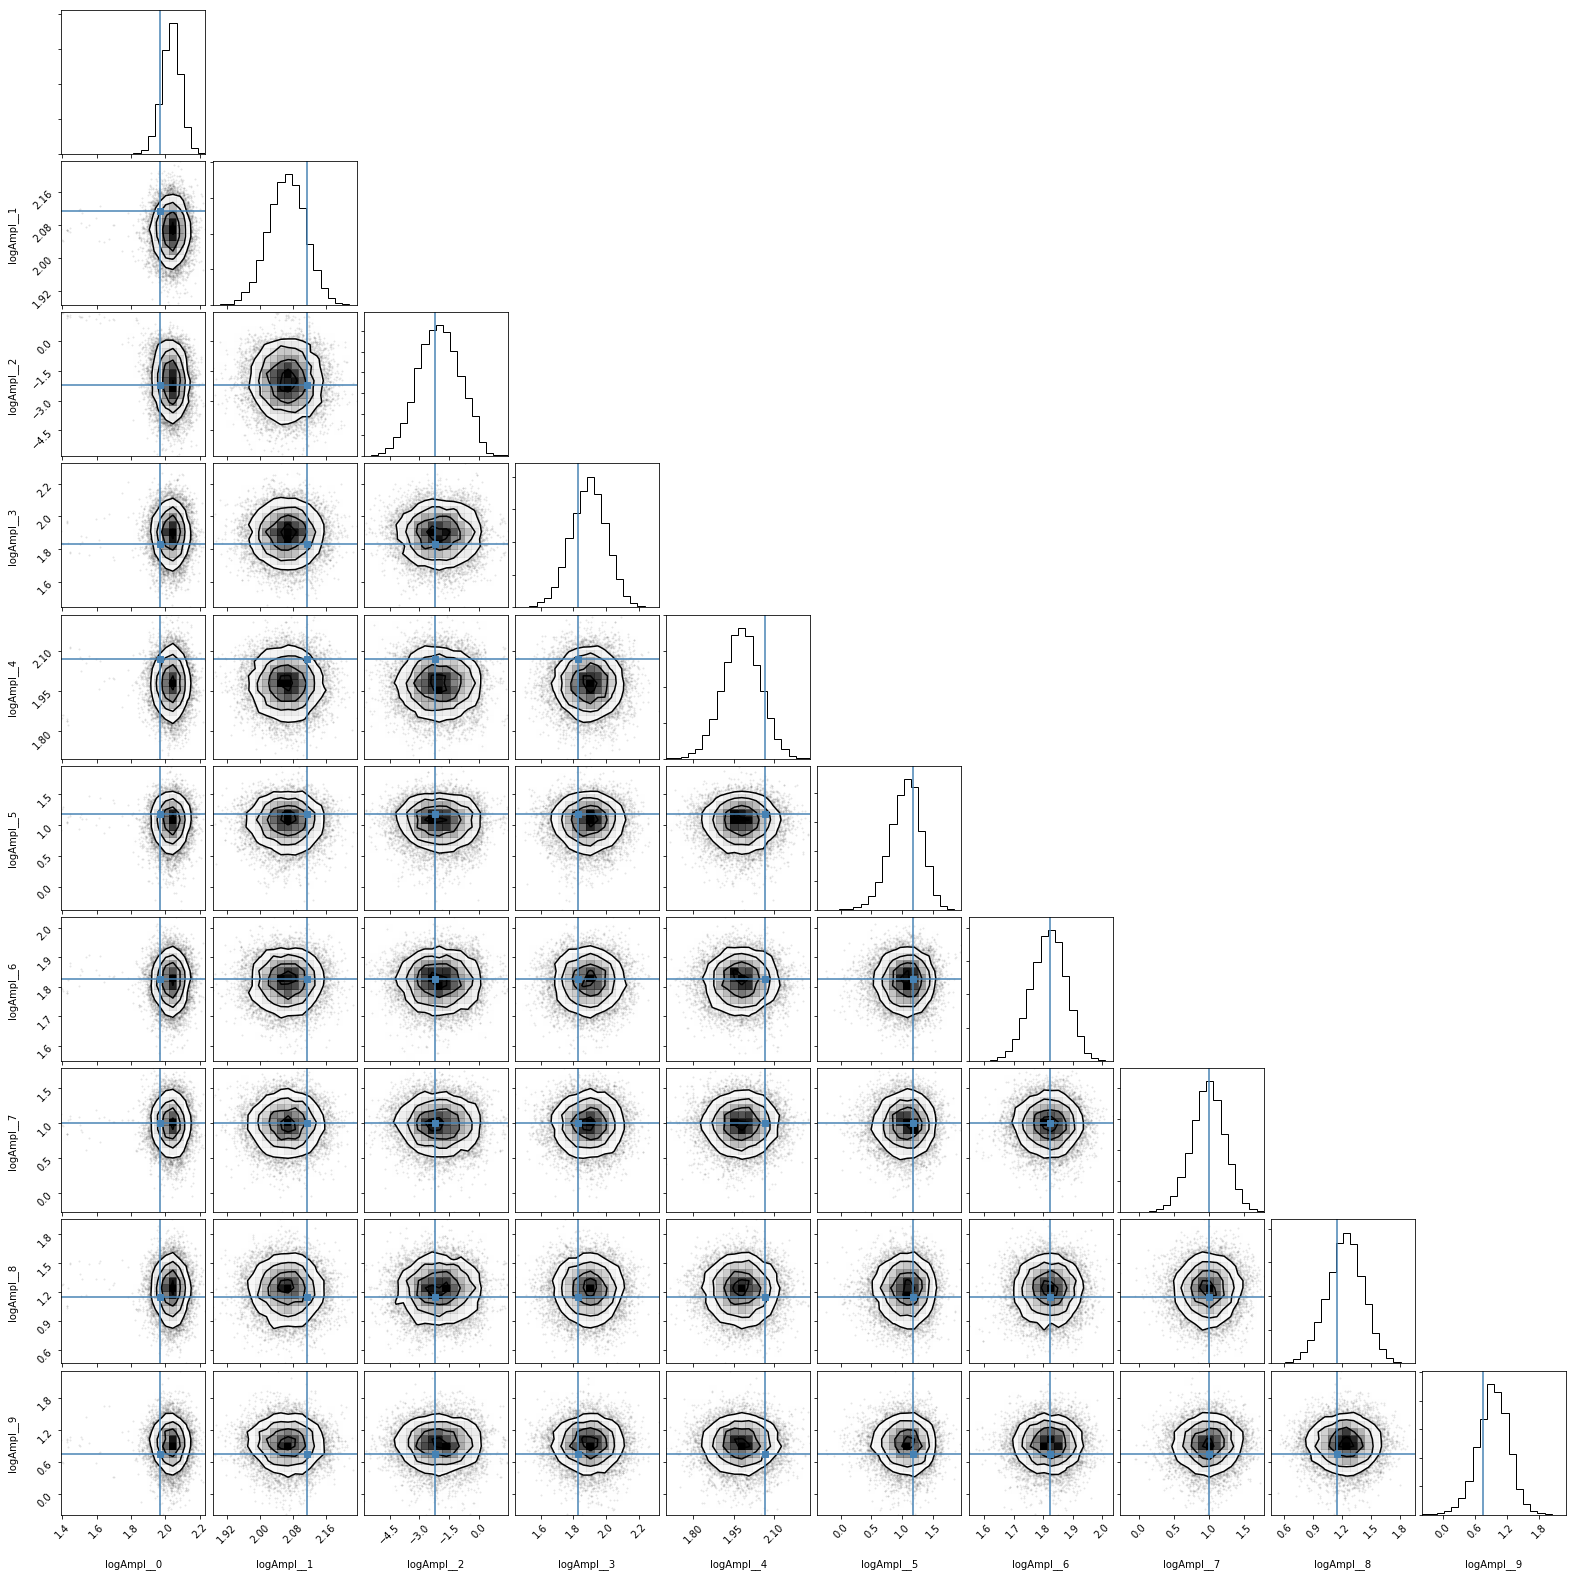

In [33]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=['logAmpl'])
corner.corner(samples, truths=np.log(ampls));

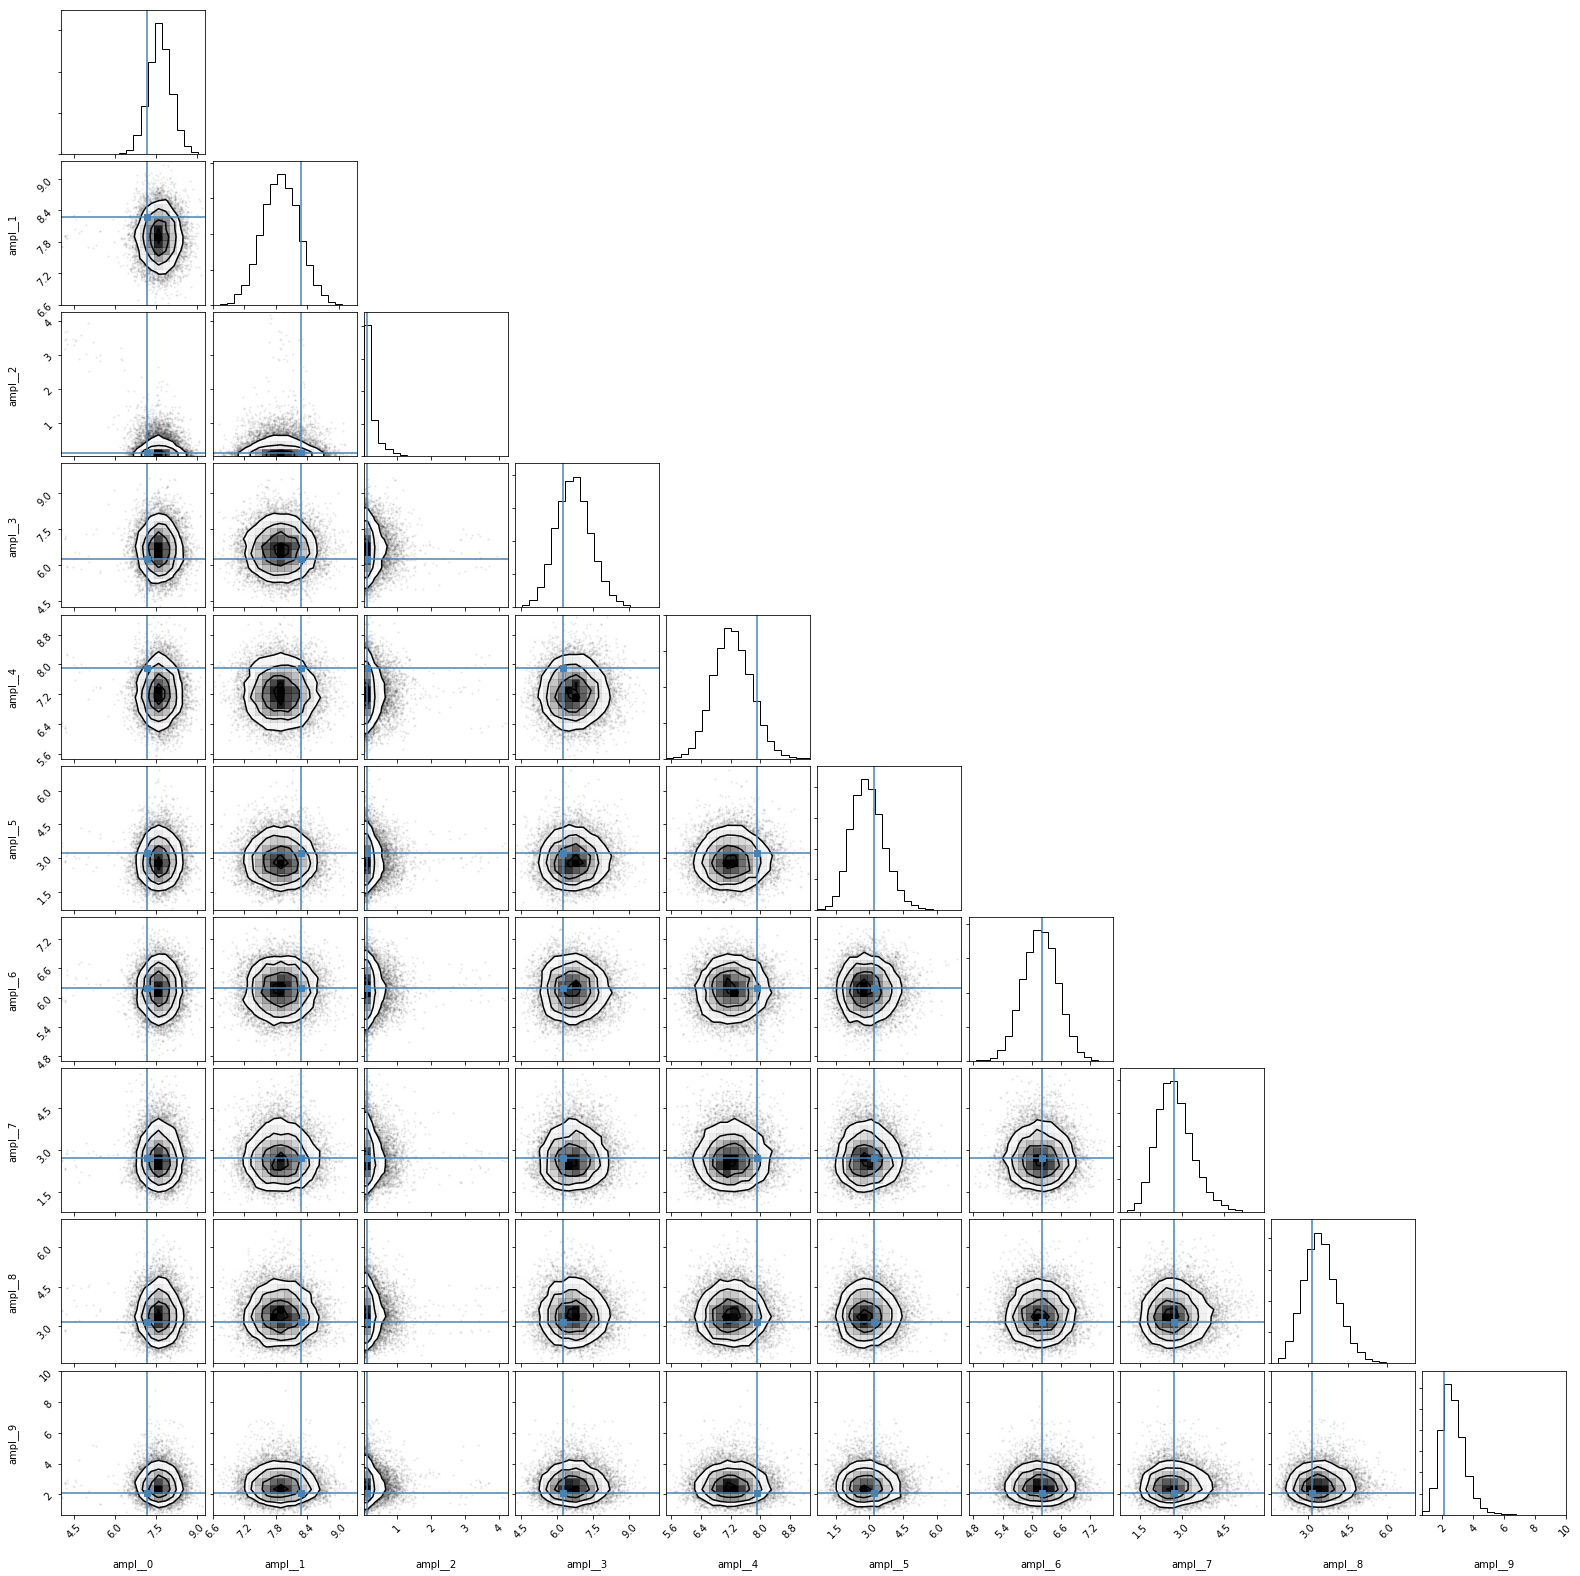

In [34]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=['ampl'])
corner.corner(samples, truths=ampls);